In [12]:
from googleapiclient.discovery import build
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt
import string
from stop_words import get_stop_words
import time
import html

In [4]:
API_KEY = 'masking api key'
REGION = "UA"
MAX_CHANNELS = 20
VIDEOS_PER_CHANNEL = 200
FONT_PATH = "/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf"

youtube = build("youtube", "v3", developerKey=API_KEY)

uk_stopwords = set(get_stop_words("uk"))
en_stopwords = set(get_stop_words("en"))
ru_stopwords = set(get_stop_words("ru"))
all_stopwords = uk_stopwords.union(en_stopwords).union(ru_stopwords)

def preprocess_text(text):
    text = html.unescape(text)
    text = text.lower()
    text = re.sub(r"http\S+", "", text)

    # Залишимо хештеги
    exclude = set(string.punctuation) - {"#"}
    text = ''.join(ch for ch in text if ch not in exclude)

    tokens = text.split()
    tokens = [word for word in tokens if word not in all_stopwords]
    return " ".join(tokens)

def get_trending_channels(region=REGION, max_results=MAX_CHANNELS):
    trending = youtube.videos().list(
        part="snippet",
        chart="mostPopular",
        regionCode=region,
        maxResults=max_results
    ).execute()

    channels = {}
    for item in trending["items"]:
        cid = item["snippet"]["channelId"]
        channels[cid] = item["snippet"]["channelTitle"]
    return channels

def get_channel_videos(channel_id, max_total=VIDEOS_PER_CHANNEL):
    all_videos = []
    next_page = None

    while len(all_videos) < max_total:
        resp = youtube.search().list(
            part="snippet",
            channelId=channel_id,
            order="date",
            maxResults=50,
            pageToken=next_page,
            type="video"
        ).execute()

        for item in resp["items"]:
            all_videos.append({
                "channelId": channel_id,
                "channelTitle": item["snippet"]["channelTitle"],
                "videoTitle": item["snippet"]["title"],
                "videoId": item["id"]["videoId"],
                "publishedAt": item["snippet"]["publishedAt"]
            })

        next_page = resp.get("nextPageToken")
        if not next_page:
            break
        time.sleep(1)  # Prevent rate limit

    return all_videos[:max_total]

channels = get_trending_channels()
all_data = []

for cid, cname in channels.items():
    print(f"Fetching videos from: {cname}")
    vids = get_channel_videos(cid)
    all_data.extend(vids)

df = pd.DataFrame(all_data)

Fetching videos from: Суспільне Запоріжжя
Fetching videos from: ТСН
Fetching videos from: Никита ЗАРАЗ
Fetching videos from: BATEK_OFFICIAL
Fetching videos from: Руслан Гладенко
Fetching videos from: Сергей Милушкин
Fetching videos from: Reel Cinema
Fetching videos from: Twi Shorts
Fetching videos from: Sergio Nee
Fetching videos from: ТНТ - шоу
Fetching videos from: Суспільне Івано-Франківськ
Fetching videos from: RCDriftTok
Fetching videos from: CRAZY GREAPA
Fetching videos from: Carter Sharer
Fetching videos from: RainBow
Fetching videos from: БЕРТ
Fetching videos from: Поле брани
Fetching videos from: История одного вокалиста
Fetching videos from: Загін Кіноманів


In [5]:
df.to_csv("youtube_video_data_backup.csv", index=False)

In [52]:
import os

BACKUP_FILE = "youtube_video_data_backup.csv"

if os.path.exists(BACKUP_FILE):
    df = pd.read_csv(BACKUP_FILE)

In [54]:
df.drop_duplicates(subset="videoId", inplace=True)

df

,channelId,channelTitle,videoTitle,videoId,publishedAt
0,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Під грубу печі сховалися і таким чином в...,RSYfuhyn57U,2025-06-01T15:39:50Z
1,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Я досі пам’ятаю день, коли російська бом...",n-MGOzWR4Ow,2025-06-01T13:01:17Z
2,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Співвідношення сил були десять до одного...,vhRX6ZnRd7U,2025-06-01T11:01:32Z
3,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Думаєш як там діти, до них не прилетіла ...",wGYDfFFe8vo,2025-06-01T09:01:22Z
4,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,Армія РФ атакувала дронами Запоріжжя: є поранена,oqk-9qtGEDU,2025-06-01T07:16:13Z
...,...,...,...,...,...
2596,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПАВЛО СКОРОХОДЬКО - ГОЛОС СІДА, ГАРРІ ПОТТЕРА⚡...",KiQ2dJSIiFo,2021-03-11T16:00:06Z
2597,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЗАРУБІЖНІ ФІЛЬМИ ЗНЯТІ В УКРАЇНІ!🤩 ПЕРЕВІЗНИК ...,XBCHOS3gSiQ,2021-02-28T16:47:26Z
2598,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЛЮБОМИР ЛЕВИЦЬКИЙ - ІНТЕРВ&#39;Ю ПРО СКАЖЕНЕ В...,0f112MWJJzc,2021-02-21T17:30:03Z
2599,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЩО ТРАПИЛОСЬ З РЕСЛЕРАМИ З QTV (КУЙ ТБ)?,j01paByxH44,2021-02-13T16:04:28Z


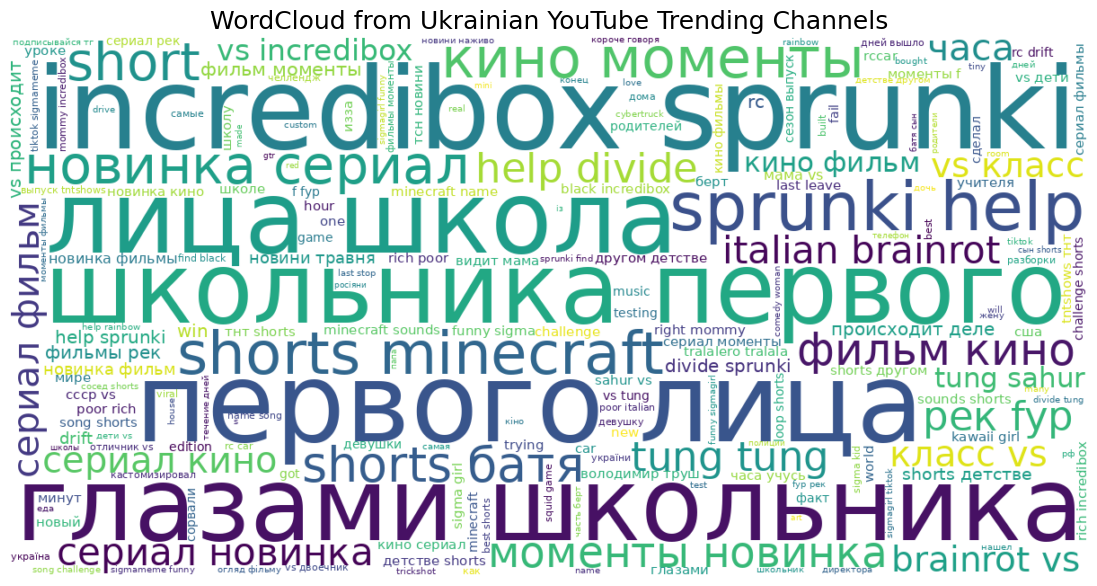

In [56]:
df["cleanTitle"] = df["videoTitle"].apply(preprocess_text)

all_text = " ".join(df["cleanTitle"])
wordcloud = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    font_path=FONT_PATH
).generate(all_text)

plt.figure(figsize=(14, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud from Ukrainian YouTube Trending Channels", fontsize=18)
plt.show()

In [57]:
df

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle
0,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Під грубу печі сховалися і таким чином в...,RSYfuhyn57U,2025-06-01T15:39:50Z,грубу печі сховалися таким чином вціліли очеви...
1,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Я досі пам’ятаю день, коли російська бом...",n-MGOzWR4Ow,2025-06-01T13:01:17Z,досі пам’ятаю російська бомба влучила будинок ...
2,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Співвідношення сил були десять до одного...,vhRX6ZnRd7U,2025-06-01T11:01:32Z,співвідношення сил штурм позицій старомайорському
3,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Думаєш як там діти, до них не прилетіла ...",wGYDfFFe8vo,2025-06-01T09:01:22Z,думаєш діти прилетіла ракета прилетіла
4,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,Армія РФ атакувала дронами Запоріжжя: є поранена,oqk-9qtGEDU,2025-06-01T07:16:13Z,армія рф атакувала дронами запоріжжя поранена
...,...,...,...,...,...,...
2596,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПАВЛО СКОРОХОДЬКО - ГОЛОС СІДА, ГАРРІ ПОТТЕРА⚡...",KiQ2dJSIiFo,2021-03-11T16:00:06Z,павло скороходько голос сіда гаррі поттера⚡️ т...
2597,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЗАРУБІЖНІ ФІЛЬМИ ЗНЯТІ В УКРАЇНІ!🤩 ПЕРЕВІЗНИК ...,XBCHOS3gSiQ,2021-02-28T16:47:26Z,зарубіжні фільми зняті україні🤩 перевізник 3 с...
2598,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЛЮБОМИР ЛЕВИЦЬКИЙ - ІНТЕРВ&#39;Ю ПРО СКАЖЕНЕ В...,0f112MWJJzc,2021-02-21T17:30:03Z,любомир левицький інтервю скажене весілля 3 ка...
2599,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЩО ТРАПИЛОСЬ З РЕСЛЕРАМИ З QTV (КУЙ ТБ)?,j01paByxH44,2021-02-13T16:04:28Z,трапилось реслерами qtv куй тб


### Препроцесинг завершено

In [66]:
from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.ensemble import IsolationForest
import re

def detect_anomalies(df):
    results = {}

    # --- Title Length Outliers (Raw) ---
    df["titleLength"] = df["videoTitle"].apply(len)
    length_mean = df["titleLength"].mean()
    length_std = df["titleLength"].std()
    df["lengthZ"] = (df["titleLength"] - length_mean) / length_std
    results["length_outliers"] = df[df["lengthZ"].abs() > 1.8]

    # --- Language Anomalies (Raw) ---
    def safe_detect_lang(text):
        try:
            return detect(text)
        except:
            return "error"

    df["lang"] = df["videoTitle"].apply(safe_detect_lang)
    results["language_anomalies"] = df[~df["lang"].isin(["uk", "en"])]

    # --- Duplicate Titles (Raw) ---
    results["duplicates"] = df[df.duplicated("videoTitle", keep=False)]

    # --- Spammy Titles (Symbol Count) ---
    df["symbolCount"] = df["videoTitle"].apply(lambda t: sum(1 for c in t if not c.isalnum() and not c.isspace()))
    results["symbol_outliers"] = df[df["symbolCount"] > df["symbolCount"].mean() + 3 * df["symbolCount"].std()]

    # --- Rare Words by TF-IDF (Cleaned) ---
    tfidf = TfidfVectorizer()
    X = tfidf.fit_transform(df["cleanTitle"])
    features = tfidf.get_feature_names_out()
    top_indices = X.max(axis=0).toarray().ravel().argsort()[-10:][::-1]
    results["rare_words"] = [features[i] for i in top_indices]

    # --- Semantic Anomalies (Cleaned) ---
    model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
    embeddings = model.encode(df["cleanTitle"].tolist())
    iso = IsolationForest(contamination=0.1, random_state=42)
    df["semAnomaly"] = iso.fit_predict(embeddings)
    results["semantic_outliers"] = df[df["semAnomaly"] == -1]

    return results

In [67]:
results = detect_anomalies(df)

In [69]:
results["length_outliers"]

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle,titleLength,lengthZ,lang,symbolCount,semAnomaly
0,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,&quot;Під грубу печі сховалися і таким чином в...,RSYfuhyn57U,2025-06-01T15:39:50Z,грубу печі сховалися таким чином вціліли очеви...,102,1.982143,uk,5,1
1,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"&quot;Я досі пам’ятаю день, коли російська бом...",n-MGOzWR4Ow,2025-06-01T13:01:17Z,досі пам’ятаю російська бомба влучила будинок ...,109,2.270352,uk,7,1
15,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,"Ситуація на Запорізькому напрямку, обстріл КАБ...",yOf6RtQgbT4,2025-05-30T18:00:06Z,ситуація запорізькому напрямку обстріл кабами ...,100,1.899798,uk,4,1
70,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,ТСН 13:00 новини 31 травня. Прощання з Сергієм...,XxYcLhUJugw,2025-05-31T11:00:56Z,тсн 1300 новини 31 травня прощання сергієм шве...,100,1.899798,uk,4,-1
97,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,ТСН З АЛЛОЮ МАЗУР! НОВИНИ ПІДСУМКИ 16 ТРАВНЯ. ...,6nVqgd6rjkE,2025-05-30T18:52:25Z,тсн аллою мазур новини підсумки 16 травня стам...,98,1.817452,uk,6,1
...,...,...,...,...,...,...,...,...,...,...,...
2415,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Дипломат,CYgi4x4x-0A,2024-12-09T20:25:51Z,дипломат,8,-1.888093,bg,0,-1
2417,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Натяк,eflNFrEZ-r8,2024-12-03T16:40:26Z,натяк,5,-2.011611,uk,0,1
2507,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПРО ЩО ФІЛЬМ &quot;ЛЮКСЕМБУРГ, ЛЮКСЕМБУРГ&quo...",K_U6N-2YxWU,2023-04-22T16:37:00Z,фільм люксембург люксембург чим закінчилось зі...,105,2.105662,uk,8,1
2594,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,МОЇ ДУМКИ ТИХІ 2 - БУДЕ ПРОДОВЖЕННЯ? ІНТЕРВ&#3...,Z2s6qlVFrUg,2021-04-01T09:14:17Z,думки тихі 2 продовження інтервю творцями ірма...,98,1.817452,uk,9,1


In [71]:
results["language_anomalies"]

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle,titleLength,lengthZ,lang,symbolCount,semAnomaly
41,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,ДОВГООЧІКУВАНЕ ЛІТО! ПОГОДА ГОТУЄ ЦІКАВИНКИ!,J-9Udr8UvpI,2025-06-01T08:00:17Z,довгоочікуване літо погода готує цікавинки,44,-0.405875,ru,2,1
45,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,Новини на 09:00 1 червня! ППО ПРАЦЮЄ В КИЄВІ! ...,5jPUfFrNqEg,2025-06-01T06:30:05Z,новини 0900 1 червня ппо працює києві тривога ...,70,0.664616,ru,3,1
49,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,НОВИНИ НАЖИВО ВЕЧІР 31 ТРАВНЯ - СУБОТА,bKFozhV0cOI,2025-05-31T21:35:48Z,новини наживо вечір 31 травня субота,38,-0.652911,ru,1,1
54,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,"НОВИНИ 20:00 ПІДСУМКИ 31 ТРАВНЯ. ПОСЛУХАЙТЕ, щ...",w3rT-PakJ50,2025-05-31T18:40:00Z,новини 2000 підсумки 31 травня послухайте зеле...,90,1.488071,bg,4,1
55,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,НОВИНИ НАЖИВО ПІДСУМКИ 31 ТРАВНЯ - СУБОТА,npFW2Psx0Kc,2025-05-31T18:13:48Z,новини наживо підсумки 31 травня субота,41,-0.529393,bg,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2595,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"РЕСЛІНГ ПОВЕРТАЄТЬСЯ! БЕЛКІН ПРО QTV, НОВАКА ...",cLHvqoPrliI,2021-03-20T15:56:12Z,реслінг повертається белкін qtv новака реслінг,56,0.088198,ru,2,1
2596,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"ПАВЛО СКОРОХОДЬКО - ГОЛОС СІДА, ГАРРІ ПОТТЕРА⚡...",KiQ2dJSIiFo,2021-03-11T16:00:06Z,павло скороходько голос сіда гаррі поттера⚡️ т...,77,0.952825,ru,7,1
2597,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЗАРУБІЖНІ ФІЛЬМИ ЗНЯТІ В УКРАЇНІ!🤩 ПЕРЕВІЗНИК ...,XBCHOS3gSiQ,2021-02-28T16:47:26Z,зарубіжні фільми зняті україні🤩 перевізник 3 с...,65,0.458752,ru,5,1
2599,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЩО ТРАПИЛОСЬ З РЕСЛЕРАМИ З QTV (КУЙ ТБ)?,j01paByxH44,2021-02-13T16:04:28Z,трапилось реслерами qtv куй тб,40,-0.570566,bg,3,1


In [72]:
results["duplicates"]

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle,titleLength,lengthZ,lang,symbolCount,semAnomaly
362,UCYsVtR0mpHEOON2YsycCFWA,BATEK_OFFICIAL,БАТЯ И РЫБАЛКА😂#shorts,Y9Vv3Z-_44I,2025-05-30T13:59:07Z,батя рыбалка😂#shorts,22,-1.311675,bg,2,1
366,UCYsVtR0mpHEOON2YsycCFWA,BATEK_OFFICIAL,ТВОЙ БАТЯ КОГДА ВЫПЬЕТ😂#shorts,A5i6Rcg4Up0,2025-05-01T13:59:46Z,батя выпьет😂#shorts,30,-0.982293,ru,2,1
372,UCYsVtR0mpHEOON2YsycCFWA,BATEK_OFFICIAL,ТЫ С ДРУГОМ В ДЕТСТВЕ 😂#shorts,iNygkPXEqfk,2025-04-09T14:03:22Z,другом детстве 😂#shorts,30,-0.982293,bg,2,1
378,UCYsVtR0mpHEOON2YsycCFWA,BATEK_OFFICIAL,ТВОЙ БАТЯ КОГДА ВЫПЬЕТ😂#shorts,FbiER2ExKeU,2025-03-11T13:40:31Z,батя выпьет😂#shorts,30,-0.982293,ru,2,1
396,UCYsVtR0mpHEOON2YsycCFWA,BATEK_OFFICIAL,ТЫ В ДЕТСТВЕ С ДРУГОМ😂#shorts,iaCQJegP9jg,2024-12-19T13:48:05Z,детстве другом😂#shorts,29,-1.023466,bg,2,1
...,...,...,...,...,...,...,...,...,...,...,...
2261,UC1OVPmCs7VxRkNedS25g6JA,БЕРТ,ОТЛИЧНИК VS ДВОЕЧНИК | Берт,mWmKj42SkO4,2022-02-17T15:00:02Z,отличник vs двоечник берт,27,-1.105811,bg,1,1
2285,UC1OVPmCs7VxRkNedS25g6JA,БЕРТ,УМНЫЙ VS ТУПОЙ// Берт,Zo8hJ_u9cbY,2021-08-29T12:58:46Z,умный vs тупой берт,21,-1.352848,bg,2,1
2291,UC1OVPmCs7VxRkNedS25g6JA,БЕРТ,УМНЫЙ VS ТУПОЙ// Берт,sgAzgX6ZFLw,2021-07-08T13:11:30Z,умный vs тупой берт,21,-1.352848,bg,2,1
2458,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Як озвучували «Тачки»?,D0CduUk1wmc,2024-01-03T18:05:13Z,озвучували «тачки»,22,-1.311675,mk,3,1


In [73]:
results["symbol_outliers"]

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle,titleLength,lengthZ,lang,symbolCount,semAnomaly
865,UC9wMQyY4n6mDkynEpkw0_GQ,Reel Cinema,Девушка пострадала из-за равнодушия полиции😠#с...,iYeh3CQf4Bk,2025-01-31T16:57:21Z,девушка пострадала изза равнодушия полиции😠#се...,95,1.693934,ru,10,1
1091,UCGa9YJJiR-Jec5y10GQxEPg,Twi Shorts,Minecraft: Making the world&#39;s largest pixe...,-DEPX7h1tPE,2023-12-14T15:00:00Z,minecraft making worlds largest pixel art😳 #sh...,64,0.417580,en,10,1
1694,UCtNBFUsxj2YVbEc5HquzFqg,Carter Sharer,$1000 RC CAR VS CARTER SHARER TEST🚗🚀 #rccars #...,e89gm5qErTw,2025-05-27T16:23:23Z,1000 rc car vs carter sharer test🚗🚀 #rccars #r...,87,1.364552,en,10,1
1696,UCtNBFUsxj2YVbEc5HquzFqg,Carter Sharer,TURNING MY BED INTO A SPEED BOAT!!🛥️🛏️ #bed #b...,rAKA2JzBayg,2025-05-25T13:57:00Z,turning bed speed boat🛥️🛏️ #bed #boat #lake #s...,86,1.323380,en,13,1
1697,UCtNBFUsxj2YVbEc5HquzFqg,Carter Sharer,$1000 CYBER TRUCK VS CARTER SHARER TEST🚒🚀 #tes...,KeoeD9-ZVtU,2025-05-24T13:57:02Z,1000 cyber truck vs carter sharer test🚒🚀 #tesl...,95,1.693934,en,10,1
2448,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Як в СРСР крали фільми? &quot;Діамантова рука&...,fMRXC1sOzTw,2024-03-11T19:37:59Z,срср крали фільми діамантова рука іронія долі ...,89,1.446898,uk,11,1
2560,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,&quot;ІЗ ЗАВ&#39;ЯЗАНИМИ ОЧИМА&quot; (BLINDFOL...,Piv2-G4ehBM,2021-12-09T15:59:32Z,із завязаними очима blindfold щось унікальне о...,80,1.076343,uk,12,1


In [75]:
results["semantic_outliers"]

,channelId,channelTitle,videoTitle,videoId,publishedAt,cleanTitle,titleLength,lengthZ,lang,symbolCount,semAnomaly
16,UCZSashx8dRHivfiJuim_OHg,Суспільне Запоріжжя,Війська РФ просунулися поблизу села Зелене Пол...,ENU3c5XVHgE,2025-05-30T16:00:23Z,війська рф просунулися поблизу села зелене пол...,93,1.611589,uk,1,-1
36,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,Новини на 16:00 1 червня! ПОТРОЩЕНІ російські ...,jYvJUbobE4s,2025-06-01T13:32:02Z,новини 1600 1 червня потрощені російські літак...,82,1.158689,uk,5,-1
43,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,Яка погода буде в перший день літа?,qGRc3M9LxBo,2025-06-01T07:11:30Z,погода літа,35,-0.776429,uk,1,-1
70,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,ТСН 13:00 новини 31 травня. Прощання з Сергієм...,XxYcLhUJugw,2025-05-31T11:00:56Z,тсн 1300 новини 31 травня прощання сергієм шве...,100,1.899798,uk,4,-1
123,UCXoJ8kY9zpLBEz-8saaT3ew,ТСН,ТСН 19:30 НАЖИВО НОВИНИ 29 ТРАВНЯ! &quot;Пощез...,AzDflHGHSF4,2025-05-29T18:35:19Z,тсн 1930 наживо новини 29 травня пощез керував...,96,1.735107,uk,8,-1
...,...,...,...,...,...,...,...,...,...,...,...
2439,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,ЯК КОЗАКИ ФЕНОМЕНОМ СТАЛИ?,eIEQNuwQVEo,2024-07-16T16:34:24Z,козаки феноменом стали,26,-1.146984,ru,1,-1
2449,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Володимиру Івасюку 75 років!,MyLV_O2WMq4,2024-03-04T09:04:21Z,володимиру івасюку 75,28,-1.064639,uk,1,-1
2474,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,Як стали популярними Зінкевич та Яремчук?,mR4zpAvNTy0,2023-09-27T13:53:39Z,стали популярними зінкевич яремчук,41,-0.529393,uk,1,-1
2548,UCig7t6LFOjS2fKkhjbVLpjw,Загін Кіноманів,"РЕКЛАМИ ВІДОМИХ БРЕНДІВ, ЯКІ ЗНЯТІ В УКРАЇНІ!",PwGuAK_H3X0,2022-02-23T17:02:25Z,реклами відомих брендів зняті україні,45,-0.364702,ru,2,-1


In [76]:
results["rare_words"]

['низкий',
 'end',
 'close',
 'людей',
 'войны',
 'стрим',
 'золота',
 'папа',
 'broke',
 'натяк']